POD attack

In [ ]:
!sudo python attacks.py 163.173.228.225 pod 2

Working
DDOS started
DDOS ended
Stoped sniffing


syn_flood attack

In [ ]:
!sudo python attacks.py 163.173.228.225 syn_flood 2

Working
DDOS started
DDOS ended
Stoped sniffing


syn_ack attack

In [ ]:
!sudo python attacks.py 163.173.228.225 syn_ack 2

Working
DDOS started
DDOS ended
Stoped sniffing


smurf attack

In [ ]:
!sudo python attacks.py 163.173.228.225 smurf 2

Working
DDOS started
DDOS ended
Stoped sniffing


Now lets analise our data from csv files and answer quesrions.

Firstly I install packages for data analisis

In [1]:
!pip install pandas matplotlib seaborn requests

You should consider upgrading via the '/Users/ivanlabiak/Desktop/Projects/python/ai4ci/bin/python -m pip install --upgrade pip' command.


To analise our data we'll use pandas, matplotlib, seaborn and collection packages. We start by reading our csv files and combining our data to one dataframe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from collections import Counter

pod_df = pd.read_csv("pod_logs.csv")
smurf_df = pd.read_csv("smurf_logs.csv")
syn_ack_df = pd.read_csv("syn_ack_logs.csv")
syn_flood_df = pd.read_csv("syn_flood_logs.csv")

# Combine all data into a single DataFrame
combined_df = pd.concat([pod_df, smurf_df, syn_ack_df, syn_flood_df], ignore_index=True)

combined_df['Packets'] = 1

/Users/ivanlabiak/Desktop/Projects/python/ai4ci/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Where are the suspect IP addresses located?


To answer that, we're going to get unique source IP addresses and using ip-api we'll get their coumtries
We're also going to count how many rows have each country and show it in the plot





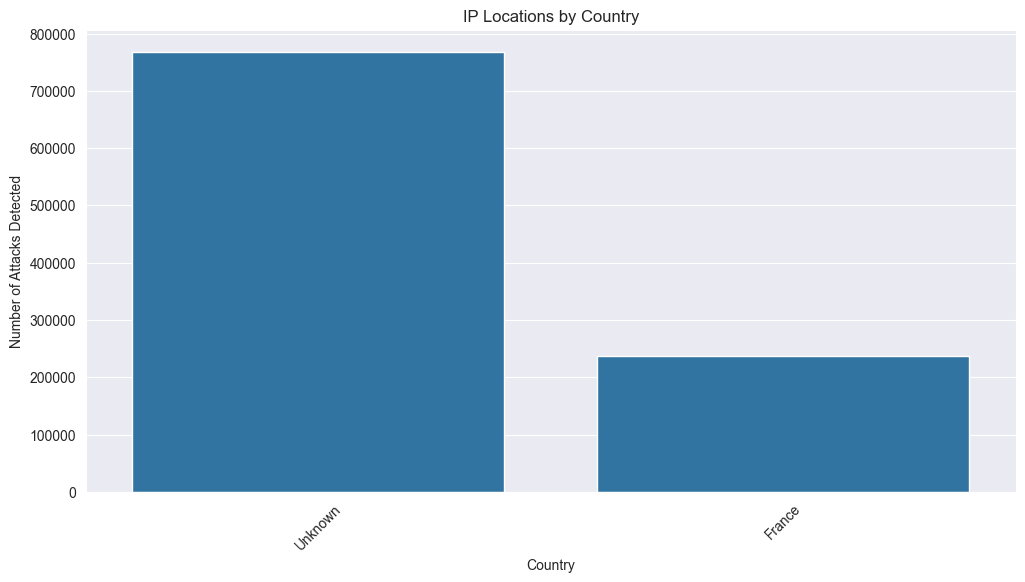

In [3]:
unique_ips = combined_df['Source IP'].unique()

def get_ip_country(ip):
    url = f"http://ip-api.com/json/{ip}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json().get('country', 'Unknown')
        else:
            return 'Unknown'
    except Exception as e:
        return 'Unknown'

# dictionary of IP -> Country
ip_country_mapping = {ip: get_ip_country(ip) for ip in unique_ips}

combined_df['Country'] = combined_df['Source IP'].map(ip_country_mapping)

# Count the occurrences of each country
country_counts = combined_df['Country'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title("IP Locations by Country")
plt.xlabel("Country")
plt.ylabel("Number of Attacks Detected")
plt.xticks(rotation=45)
plt.show()

After competing that code we can see that suspect IP is either unknown or is coming from France

Next question: What is the attack that generated more packets?

To show that, we neet to group data by attack types and show sum of the packets

Attack that generated the most packets: syn_ack


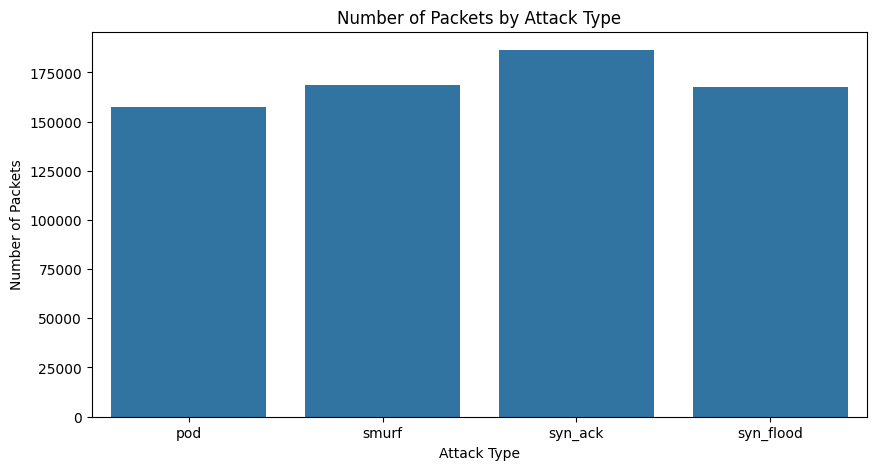

In [ ]:
packets_by_attack = combined_df.groupby('Attack Type')['Packets'].sum()

max_packets_attack = packets_by_attack.idxmax()
print(f"Attack that generated the most packets: {max_packets_attack}")

plt.figure(figsize=(10, 5))
sns.barplot(x=packets_by_attack.index, y=packets_by_attack.values)
plt.title("Number of Packets by Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Number of Packets")
plt.show()

On the plot we can see that SYN-ACK Flood Attack generated more packets than other attacks.

Next question:
What is the attack that generated the largest traffic in terms of bytes?

To get a resalt, we need to group data by attack type again, but this time, we need to get sum of the Bytes.

After that, we can show it in plot

Attack that generated the largest traffic (in bytes): pod


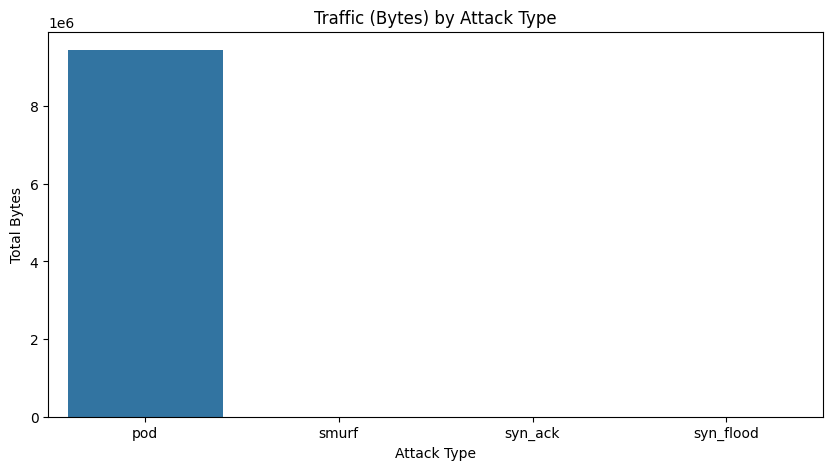

In [ ]:
traffic_by_attack = combined_df.groupby('Attack Type')['Bytes'].sum()

max_traffic_attack = traffic_by_attack.idxmax()
print(f"Attack that generated the largest traffic (in bytes): {max_traffic_attack}")

plt.figure(figsize=(10, 5))
sns.barplot(x=traffic_by_attack.index, y=traffic_by_attack.values)
plt.title("Traffic (Bytes) by Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Total Bytes")
plt.show()

We can see that Pod attack generated most bytes. That's because for other attacks SniffnDetect didn't provide bytes values and we passed it as 0

And finally, we need to asnwer Whick attack generated more bytes per second?

To do that, I converted date format from string to timestamp, and then calculater traffic and duration of each attack type.

After this, we can show this data on the plot

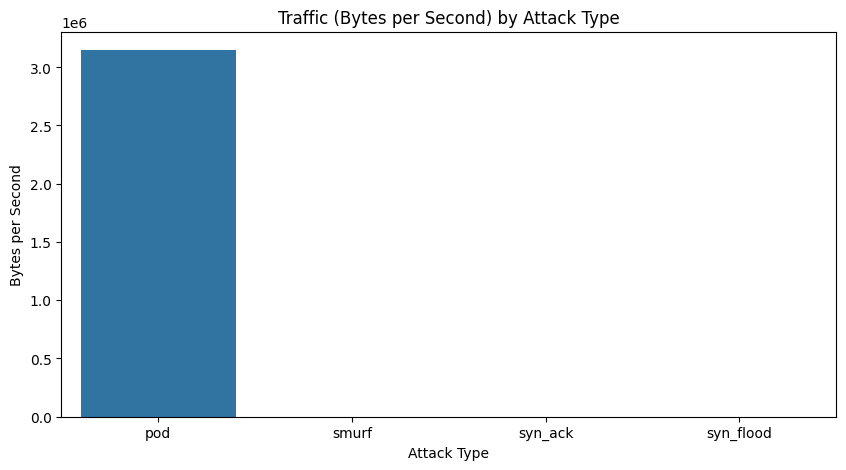

In [ ]:
combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

attack_duration = combined_df.groupby('Attack Type')['Timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds() + 1)  # Adding 1 to handle zero duration cases
traffic_by_attack = combined_df.groupby('Attack Type')['Bytes'].sum()

# Calculate bytes per second for each attack type
bytes_per_second = traffic_by_attack / attack_duration

plt.figure(figsize=(10, 5))
sns.barplot(x=bytes_per_second.index, y=bytes_per_second.values)
plt.title("Traffic (Bytes per Second) by Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Bytes per Second")
plt.show()

We can see that pod attack generated most bytes per second